# Project: Machine Learning with Spark
# By: YASH ANAND (BT20CSE186)

#### Introduction

The objective of this project is to use different Spark and machine learning libraries to build a predictive model.

The provided dataset comes from [UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset). It contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.

The task of this project is to predict hourly bike demand based on the provided features. Since the target variable is known, supervised learning is thus used.

As the target is continuous, we will build several regression models, tune them and compare the results.

We will proceed the project with the following steps:

1. Load and preprocess the data
2. Build a first linear regression model
3. Tune linear regression model
4. Result analysis
5. Feature engineering
6. Try other regression models

#### 1. Load and preprocess the data

The dataset is provided under csv format. The following code loads it by keeping the header and the original schema.

In [ ]:
#!pip install
from pyspark.shell import spark
data = spark.read.csv('Bike_Rental_UCI_dataset.csv', header=True, inferSchema=True)

Let's have a look at 5 first rows of the dataset.

In [ ]:
data.show(5)

+------+---+----+---+-------+----------+----------+----+----+---------+---------+----+------+
|season| yr|mnth| hr|holiday|workingday|weathersit|temp| hum|windspeed|dayOfWeek|days|demand|
+------+---+----+---+-------+----------+----------+----+----+---------+---------+----+------+
|     1|  0|   1|  0|      0|         0|         1|0.24|0.81|      0.0|      Sat|   0|    16|
|     1|  0|   1|  1|      0|         0|         1|0.22| 0.8|      0.0|      Sat|   0|    40|
|     1|  0|   1|  2|      0|         0|         1|0.22| 0.8|      0.0|      Sat|   0|    32|
|     1|  0|   1|  3|      0|         0|         1|0.24|0.75|      0.0|      Sat|   0|    13|
|     1|  0|   1|  4|      0|         0|         1|0.24|0.75|      0.0|      Sat|   0|     1|
+------+---+----+---+-------+----------+----------+----+----+---------+---------+----+------+
only showing top 5 rows



According to [UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset), here is a short description of each feature in the dataset:

- season : season (1: winter, 2: spring, 3: summer, 4: fall)
- yr : year (0: 2011, 1: 2012)
- mnth : month (1 to 12)
- hr : hour (0 to 23)
- holiday : whether day is holiday or not (extracted from [Web Link](https://dchr.dc.gov/page/holiday-schedules))
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit :
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- dayOfWeek: day of the week
- demand: count of total rental bikes (TARGET VARIABLE)

In [ ]:
data.printSchema()

root
 |-- season: integer (nullable = true)
 |-- yr: integer (nullable = true)
 |-- mnth: integer (nullable = true)
 |-- hr: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- weathersit: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- hum: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- dayOfWeek: string (nullable = true)
 |-- days: integer (nullable = true)
 |-- demand: integer (nullable = true)



Almost all columns are of numerical values, except dayOfWeek. In order to get the data prepared for machine learning task, we need to encode days of week with numerical values.
Let's check the different values in dayOfWeek column.

In [ ]:
data.select("dayOfWeek").distinct().show()

+---------+
|dayOfWeek|
+---------+
|      Sun|
|      Mon|
|      Sat|
|      Wed|
|      Tue|
|      Fri|
|      Thr|
+---------+



Hereunder, we create a mapping dictionary to map each value in dayOfWeek column to a numerical value. Monday is encoded as 0, Tuesday is encoded as 1 and so on.

In [ ]:
from itertools import chain
from pyspark.sql.functions import create_map, lit
mapping = {'Mon': 0,
           'Tue': 1,
           'Wed': 2,
           'Thr': 3,
           'Fri': 4,
           'Sat': 5,
           'Sun': 6}

mapping_expr = create_map([lit(x) for x in chain(*mapping.items())])

data = data.withColumn('day_cat', mapping_expr[data['dayOfWeek']])

Let's have a look at the data after encoding dayOfWeek.

In [ ]:
data.show(5)

+------+---+----+---+-------+----------+----------+----+----+---------+---------+----+------+-------+
|season| yr|mnth| hr|holiday|workingday|weathersit|temp| hum|windspeed|dayOfWeek|days|demand|day_cat|
+------+---+----+---+-------+----------+----------+----+----+---------+---------+----+------+-------+
|     1|  0|   1|  0|      0|         0|         1|0.24|0.81|      0.0|      Sat|   0|    16|      5|
|     1|  0|   1|  1|      0|         0|         1|0.22| 0.8|      0.0|      Sat|   0|    40|      5|
|     1|  0|   1|  2|      0|         0|         1|0.22| 0.8|      0.0|      Sat|   0|    32|      5|
|     1|  0|   1|  3|      0|         0|         1|0.24|0.75|      0.0|      Sat|   0|    13|      5|
|     1|  0|   1|  4|      0|         0|         1|0.24|0.75|      0.0|      Sat|   0|     1|      5|
+------+---+----+---+-------+----------+----------+----+----+---------+---------+----+------+-------+
only showing top 5 rows



In order to train machine learning models, we need a transformer that combines a list of columns into a single vector column. For this purpose, we use VectorAssembler, that takes all the features (except dayOfWeek) as input and outputs a new column named "features".

In [ ]:
from pyspark.ml.feature import VectorAssembler, VectorIndexer

In [ ]:
# create a feature vector
vectorAssembler = VectorAssembler(
  inputCols= [
    'season',
    'yr',
    'mnth',
    'hr',
    'holiday',
    'workingday',
    'weathersit',
    'temp',
    'hum',
    'windspeed',
    'days',
    'day_cat'
    ],
   outputCol = 'features'
 )

output = vectorAssembler.transform(data)

Have a look at the features and target after applying VectorAssembler.

In [ ]:
output.select("features", "demand").show(10, truncate=False)

+------------------------------------------------------+------+
|features                                              |demand|
+------------------------------------------------------+------+
|(12,[0,2,6,7,8,11],[1.0,1.0,1.0,0.24,0.81,5.0])       |16    |
|[1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.22,0.8,0.0,0.0,5.0]    |40    |
|[1.0,0.0,1.0,2.0,0.0,0.0,1.0,0.22,0.8,0.0,0.0,5.0]    |32    |
|[1.0,0.0,1.0,3.0,0.0,0.0,1.0,0.24,0.75,0.0,0.0,5.0]   |13    |
|[1.0,0.0,1.0,4.0,0.0,0.0,1.0,0.24,0.75,0.0,0.0,5.0]   |1     |
|[1.0,0.0,1.0,5.0,0.0,0.0,2.0,0.24,0.75,0.0896,0.0,5.0]|1     |
|[1.0,0.0,1.0,6.0,0.0,0.0,1.0,0.22,0.8,0.0,0.0,5.0]    |2     |
|[1.0,0.0,1.0,7.0,0.0,0.0,1.0,0.2,0.86,0.0,0.0,5.0]    |3     |
|[1.0,0.0,1.0,8.0,0.0,0.0,1.0,0.24,0.75,0.0,0.0,5.0]   |8     |
|[1.0,0.0,1.0,9.0,0.0,0.0,1.0,0.32,0.76,0.0,0.0,5.0]   |14    |
+------------------------------------------------------+------+
only showing top 10 rows



We split data into train and test set.

In [ ]:
train, test = output.randomSplit([0.8, 0.2])
print ("We have %d training examples and %d test examples." % (train.count(), test.count()))

We have 14018 training examples and 3361 test examples.


In [ ]:
train.cache()
test.cache()

DataFrame[season: int, yr: int, mnth: int, hr: int, holiday: int, workingday: int, weathersit: int, temp: double, hum: double, windspeed: double, dayOfWeek: string, days: int, demand: int, day_cat: int, features: vector]

#### 2. Build a first linear regression model

In this section, we build a first linear regression model with some pre-defined hyperparameters. After fitting the model into training set, we will display the evaluation metrics (Mean Absolute Error and R2) on training set and on test set.

In [ ]:
# import Linear Regression module
from pyspark.ml.regression import LinearRegression

In [ ]:
# initialize Linear Regression model with some hyperparameters
#A value of 0 corresponds to L2 regularization (ridge regression), while a value of 1 corresponds to L1 regularization (lasso regression).
lr = LinearRegression(maxIter=100, elasticNetParam=0.3, featuresCol="features", labelCol="demand")

In [ ]:
# fit to training set
lrm = lr.fit(train)

In [ ]:
# print out MAE and R2 on train data
trainingSummary = lrm.summary
print("Mean Absolute Error (MAE) on train data = %f" % trainingSummary.meanAbsoluteError)
print("R Squared (R2) on train data = %f" % trainingSummary.r2)

Mean Absolute Error (MAE) on train data = 106.057872
R Squared (R2) on train data = 0.388387


MAE measures the absolute differences between predicted values by the model and the actual values. However, MAE alone is meaningless until we compare with the actual “demand” value, such as mean and standard deviation.

In [ ]:
train.select("demand").describe().show()

+-------+------------------+
|summary|            demand|
+-------+------------------+
|  count|             14018|
|   mean|189.62077329148238|
| stddev|181.17341836384028|
|    min|                 1|
|    max|               977|
+-------+------------------+



It can be seen that the demand in training set has a mean of 188.9 and a standard deviation of 180.3. While our Mean Absolute Error is 105.7 which is lower than standard deviation. This is a not bad result.

However, R2 square is 0.387. This metric indicates that in our model, approximate 38.7% of the variability in “demand” can be explained using the model. This is an average result and there is still room for improvement.

Next, we will make predictions on the test data and print out MAE and R2.

In [ ]:
# make predictions on test data
lr_preds = lrm.transform(test)

lr_preds.select("prediction", "demand", "features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator

lr_evaluator = RegressionEvaluator(predictionCol="prediction",\
                                   labelCol="demand")

# print out MAE and R2 on test data
print("Mean Absolute Error (MAE) on test data = %g" % lr_evaluator.evaluate(lr_preds, {lr_evaluator.metricName: "mae"}))
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_preds, {lr_evaluator.metricName: "r2"}))

+-------------------+------+--------------------+
|         prediction|demand|            features|
+-------------------+------+--------------------+
|-47.762357046179204|    28|[1.0,0.0,1.0,0.0,...|
|  -47.6395702968296|     7|[1.0,0.0,1.0,0.0,...|
| -42.15165315140863|    11|[1.0,0.0,1.0,0.0,...|
|-113.70460952384045|     7|[1.0,0.0,1.0,0.0,...|
|   -79.698988964795|     9|[1.0,0.0,1.0,0.0,...|
+-------------------+------+--------------------+
only showing top 5 rows

Mean Absolute Error (MAE) on test data = 106.038
R Squared (R2) on test data = 0.382984


While R2 is approximately same as on training set, MAE is a bit worse.

In next section, we will tune this Linear Regression model by doing cross validation.

#### 3. Tune linear regression model

In this section, we tune the linear regression using cross-validation. We will build a pipeline and search for best parameters in a parameter grid.

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

We print out the parameters explanation in order to build parameter grid.

In [ ]:
lr.explainParams()

'aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)\nelasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.3)\nepsilon: The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber (default: 1.35)\nfeaturesCol: features column name. (default: features, current: features)\nfitIntercept: whether to fit an intercept term. (default: True)\nlabelCol: label column name. (default: label, current: demand)\nloss: The loss function to be optimized. Supported options: squaredError, huber. (default: squaredError)\nmaxBlockSizeInMB: maximum memory in MB for stacking input data into blocks. Data is stacked within partitions. If more than remaining data size in a partition then it is adjusted to the data size. Default 0.0 represents choosing optimal value, depends on specific algorithm. Must be >= 0. (default: 0.0)\nmaxI

We choose to tune:
- number of iterations
- regularization parameter
- elastic net parameter
- solver algorithm for optimization

In [ ]:
pipeLine = Pipeline()
pipeLine.setStages([lr])

gridBuilder = ParamGridBuilder().addGrid(lr.maxIter, [10, 50, 100, 150, 200])\
                                .addGrid(lr.regParam, [0, 10, 100, 1000])\
                                .addGrid(lr.elasticNetParam, [0, 0.1, 0.3, 0.7, 1.0])\
                                .addGrid(lr.solver, ["auto", "normal", "l-bfgs"])\
                                .build()

cv = CrossValidator(estimator = lr,
                    estimatorParamMaps = gridBuilder,
                    evaluator = lr_evaluator)

In [ ]:
cvm = cv.fit(train)

After fitting the cross validation on training set, we print out the best model parameters.

In [ ]:
best_lr_model = cvm.bestModel
best_lr_model.explainParams()

'aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)\nelasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.0)\nepsilon: The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber (default: 1.35)\nfeaturesCol: features column name. (default: features, current: features)\nfitIntercept: whether to fit an intercept term. (default: True)\nlabelCol: label column name. (default: label, current: demand)\nloss: The loss function to be optimized. Supported options: squaredError, huber. (default: squaredError)\nmaxBlockSizeInMB: maximum memory in MB for stacking input data into blocks. Data is stacked within partitions. If more than remaining data size in a partition then it is adjusted to the data size. Default 0.0 represents choosing optimal value, depends on specific algorithm. Must be >= 0. (default: 0.0)\nmaxI

The best model has the following parameters:
- number of iterations: 10
- regularization parameter: 0.0
- elastic net parameter: 0.0
- solver algorithm for optimization: l-bfgs

Next, we print out MAE and R2 score on training and test set.

In [ ]:
# print out MAE and R2 on train data
best_lr_summary = best_lr_model.summary

print("Mean Absolute Error (MAE) on train data = %f" % best_lr_summary.meanAbsoluteError)
print("R Squared (R2) on train data = %f" % best_lr_summary.r2)

Mean Absolute Error (MAE) on train data = 106.057873
R Squared (R2) on train data = 0.388387


In [ ]:
# make predictions on test data
best_lr_preds = best_lr_model.transform(test)

best_lr_preds.select("prediction", "demand", "features").show(5)

# print out MAE and R2 on test data
print("Mean Absolute Error (MAE) on test data = %g" % lr_evaluator.evaluate(best_lr_preds, {lr_evaluator.metricName: "mae"}))
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(best_lr_preds, {lr_evaluator.metricName: "r2"}))

+-------------------+------+--------------------+
|         prediction|demand|            features|
+-------------------+------+--------------------+
|-47.762354321750365|    28|[1.0,0.0,1.0,0.0,...|
|-47.639536155350285|     7|[1.0,0.0,1.0,0.0,...|
| -42.15166089602713|    11|[1.0,0.0,1.0,0.0,...|
|-113.70461478807505|     7|[1.0,0.0,1.0,0.0,...|
| -79.69894391182399|     9|[1.0,0.0,1.0,0.0,...|
+-------------------+------+--------------------+
only showing top 5 rows

Mean Absolute Error (MAE) on test data = 106.038
R Squared (R2) on test data = 0.382984


It can be seen that MAE and R2 score on test set are slighly compared to the model built in previous section.

#### 4. Result analysis

In this section, we will compare true demand with model prediction to understand where the model performs well and where it performs badly.

We will be using best_lr_preds dataframe from previous section, which contains prediction made by best Linear Regression model after cross validation.

Let's display 5 first rows of best_lr_preds to see how it looks like.

In [ ]:
best_lr_preds.show(5)

+------+---+----+---+-------+----------+----------+----+----+-------------------+---------+----+------+-------+--------------------+-------------------+
|season| yr|mnth| hr|holiday|workingday|weathersit|temp| hum|          windspeed|dayOfWeek|days|demand|day_cat|            features|         prediction|
+------+---+----+---+-------+----------+----------+----+----+-------------------+---------+----+------+-------+--------------------+-------------------+
|     1|  0|   1|  0|      0|         0|         1|0.18|0.55|                0.0|      Sat|  13|    28|      5|[1.0,0.0,1.0,0.0,...|-47.762354321750365|
|     1|  0|   1|  0|      0|         1|         1|0.06|0.41|0.19399999999999998|      Mon|  21|     7|      0|[1.0,0.0,1.0,0.0,...|-47.639536155350285|
|     1|  0|   1|  0|      0|         1|         1|0.18|0.55|                0.0|      Thr|   4|    11|      3|[1.0,0.0,1.0,0.0,...| -42.15166089602713|
|     1|  0|   1|  0|      0|         1|         2|0.16|0.86|             0.0896| 

In order to understand where the linear regression model performs well or badly, we will group by the average and standard deviation of real demand and prediction by hour, season and month. To visualize the gap easily, we will prioritize charts over tables.

In [ ]:
import pyspark.sql.functions as F

Average and standard deviation of real demand and prediction by **hour**:

Text(0, 0.5, 'Demand and Prediction')

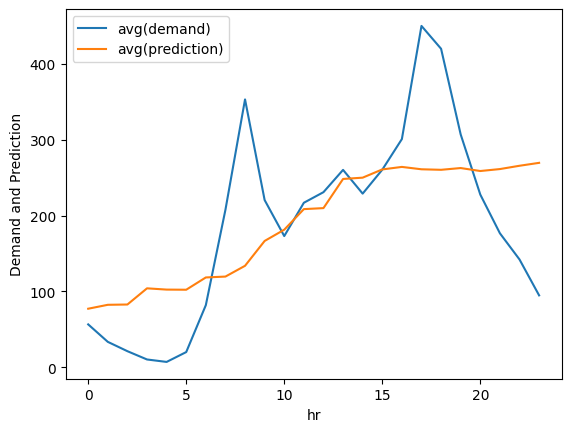

In [ ]:
# average demand and average prediction by hour
ax = best_lr_preds.groupBy('hr')\
             .agg(F.avg('demand'), F.avg('prediction'))\
             .orderBy('hr', ascending=True)\
             .toPandas()\
             .plot.line(x="hr", y=["avg(demand)", "avg(prediction)"])
ax.set_ylabel('Demand and Prediction')

Text(0, 0.5, 'Demand and Prediction')

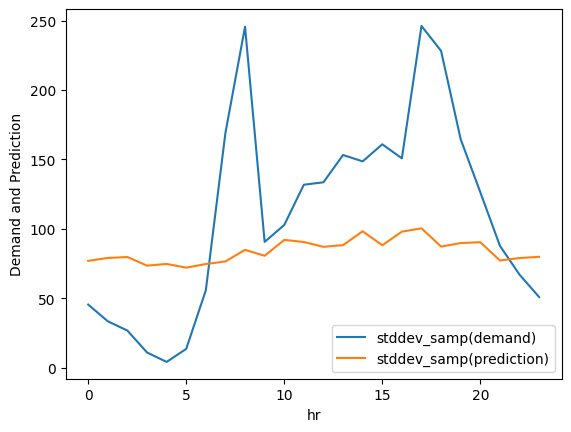

In [ ]:
# standard deviation of demand and prediction by hour
import matplotlib.pyplot as plt
ax = best_lr_preds.groupBy('hr')\
             .agg(F.stddev('demand'), F.stddev('prediction'))\
             .orderBy('hr', ascending=True)\
             .toPandas()\
             .plot.line(x="hr", y=["stddev_samp(demand)", "stddev_samp(prediction)"])
ax.set_ylabel('Demand and Prediction')


Linear regression model is not able to capture the demand pattern: average and standard deviation of prediction are pretty far from those of real demand. Especially on rush hours, when both average and standard deviation of real demand are at the peak, the model fails to make a decent prediction.

Average and standard deviation of real demand and prediction by **season**:

Text(0, 0.5, 'Demand and Prediction')

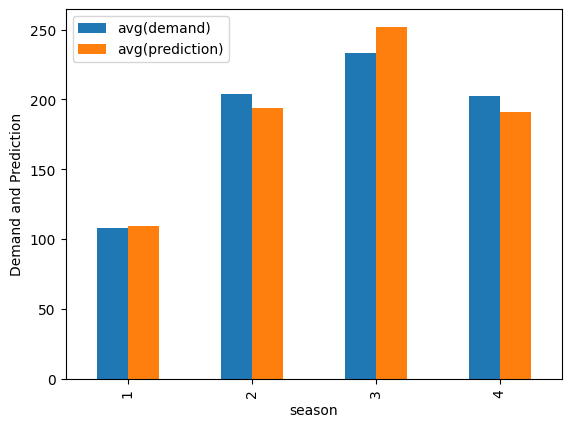

In [ ]:
# average demand and average prediction by season
ax = best_lr_preds.groupBy('season')\
             .agg(F.avg('demand'), F.avg('prediction'))\
             .orderBy('season', ascending=True)\
             .toPandas()\
             .plot.bar(x="season", y=["avg(demand)", "avg(prediction)"])
ax.set_ylabel('Demand and Prediction')

Text(0, 0.5, 'Demand and Prediction')

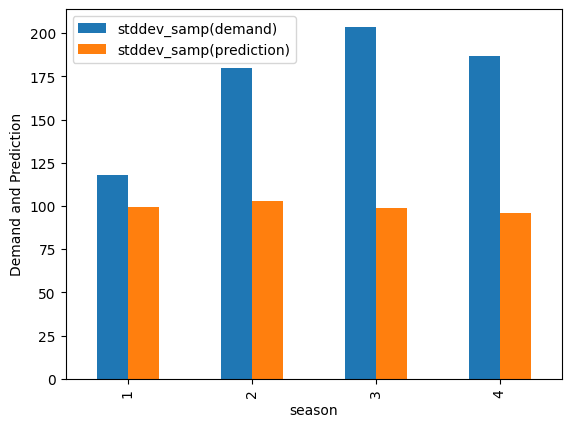

In [ ]:
# standard deviation of demand and prediction by season
ax = best_lr_preds.groupBy('season')\
             .agg(F.stddev('demand'), F.stddev('prediction'))\
             .orderBy('season', ascending=True)\
             .toPandas()\
             .plot.bar(x="season", y=["stddev_samp(demand)", "stddev_samp(prediction)"])
ax.set_ylabel('Demand and Prediction')

The model's average prediction per season is pretty near the average target value. This is also true with standard deviation in Spring (season 1).
However, for remaining seasons, there is still room for improvement since standard deviation of real demand and that of prediction are far from each other.

Average and standard deviation of real demand and prediction by **month**:

Text(0, 0.5, 'Demand and Prediction')

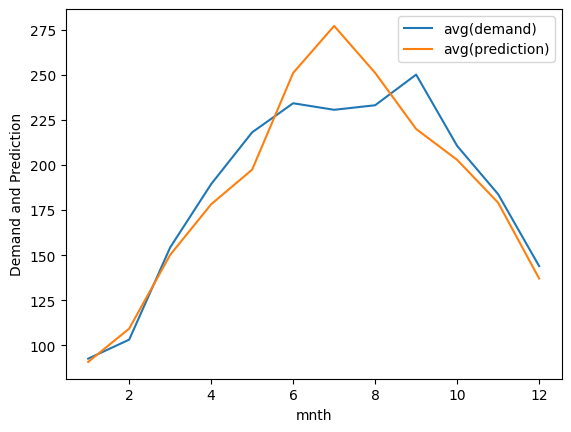

In [ ]:
# average demand and average prediction by month
ax = best_lr_preds.groupBy('mnth')\
             .agg(F.avg('demand'), F.avg('prediction'))\
             .orderBy('mnth', ascending=True)\
             .toPandas()\
             .plot.line(x="mnth", y=["avg(demand)", "avg(prediction)"])
ax.set_ylabel('Demand and Prediction')

Text(0, 0.5, 'Demand and Prediction')

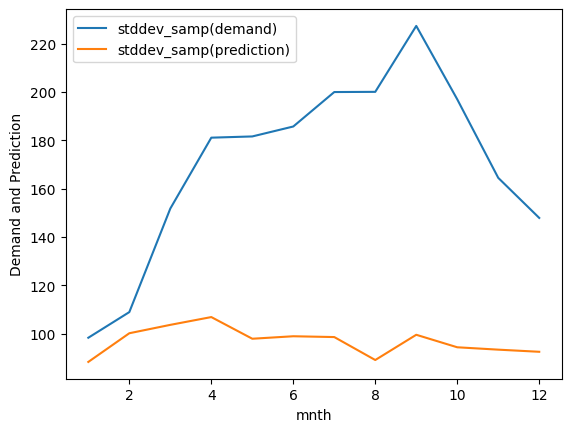

In [ ]:
# standard deviation of demand and prediction by month
ax = best_lr_preds.groupBy('mnth')\
             .agg(F.stddev('demand'), F.stddev('prediction'))\
             .orderBy('mnth', ascending=True)\
             .toPandas()\
             .plot.line(x="mnth", y=["stddev_samp(demand)", "stddev_samp(prediction)"])
ax.set_ylabel('Demand and Prediction')

Same as season, the model captures pretty well monthly trend in average demand. In contrast, the model doesn't seem to understand the trend in standard deviation.

#### 5. Feature engineering

In previous sections, we built, trained and tuned linear regression model on the provided dataset, without taking care of categorical features.
Indeed, we treated categorical features in same manner as numerical features. For example, season can have value 1, 2, 3 and 4 but this represent four different seasons thus should be taken as categorical features.

In this section, we will create dummy variables from categorical features in order to improve the accuracy of the model. These categorical features include: season, mnth, hr, weathersit and day_cat. Yr, holiday and workingday take either 0 or 1 as value, thus are not included in the categorical features from which we'll create dummy variables.

In [ ]:
# have a look at the data
data.show(5)

+------+---+----+---+-------+----------+----------+----+----+---------+---------+----+------+-------+
|season| yr|mnth| hr|holiday|workingday|weathersit|temp| hum|windspeed|dayOfWeek|days|demand|day_cat|
+------+---+----+---+-------+----------+----------+----+----+---------+---------+----+------+-------+
|     1|  0|   1|  0|      0|         0|         1|0.24|0.81|      0.0|      Sat|   0|    16|      5|
|     1|  0|   1|  1|      0|         0|         1|0.22| 0.8|      0.0|      Sat|   0|    40|      5|
|     1|  0|   1|  2|      0|         0|         1|0.22| 0.8|      0.0|      Sat|   0|    32|      5|
|     1|  0|   1|  3|      0|         0|         1|0.24|0.75|      0.0|      Sat|   0|    13|      5|
|     1|  0|   1|  4|      0|         0|         1|0.24|0.75|      0.0|      Sat|   0|     1|      5|
+------+---+----+---+-------+----------+----------+----+----+---------+---------+----+------+-------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql.functions import col

cat_cols = ['season', 'mnth', 'hr', 'weathersit', 'day_cat']

indexers = [
    StringIndexer(inputCol=col, outputCol="{0}_indexed".format(col))
    for col in cat_cols
]

encoders = [
    OneHotEncoder(
        inputCol=indexer.getOutputCol(),
        outputCol="{0}_encoded".format(indexer.getOutputCol()))
    for indexer in indexers
]

assembler = VectorAssembler(
    inputCols=[encoder.getOutputCol() for encoder in encoders],
    outputCol="features"
)


pipeline = Pipeline(stages=indexers + encoders + [assembler])
data_transformed = pipeline.fit(data).transform(data)
data_transformed.show(5)

+------+---+----+---+-------+----------+----------+----+----+---------+---------+----+------+-------+--------------+------------+----------+------------------+---------------+----------------------+--------------------+------------------+--------------------------+-----------------------+--------------------+
|season| yr|mnth| hr|holiday|workingday|weathersit|temp| hum|windspeed|dayOfWeek|days|demand|day_cat|season_indexed|mnth_indexed|hr_indexed|weathersit_indexed|day_cat_indexed|season_indexed_encoded|mnth_indexed_encoded|hr_indexed_encoded|weathersit_indexed_encoded|day_cat_indexed_encoded|            features|
+------+---+----+---+-------+----------+----------+----+----+---------+---------+----+------+-------+--------------+------------+----------+------------------+---------------+----------------------+--------------------+------------------+--------------------------+-----------------------+--------------------+
|     1|  0|   1|  0|      0|         0|         1|0.24|0.81|      

In [ ]:
train, test = data_transformed.randomSplit([0.8, 0.2])
print ("We have %d training examples and %d test examples." % (train.count(), test.count()))

We have 13913 training examples and 3466 test examples.


In [ ]:
train.cache()
test.cache()

DataFrame[season: int, yr: int, mnth: int, hr: int, holiday: int, workingday: int, weathersit: int, temp: double, hum: double, windspeed: double, dayOfWeek: string, days: int, demand: int, day_cat: int, season_indexed: double, mnth_indexed: double, hr_indexed: double, weathersit_indexed: double, day_cat_indexed: double, season_indexed_encoded: vector, mnth_indexed_encoded: vector, hr_indexed_encoded: vector, weathersit_indexed_encoded: vector, day_cat_indexed_encoded: vector, features: vector]

In [ ]:
# initialize Linear Regression model with some hyperparameters
lr = LinearRegression(maxIter=100, elasticNetParam=0.3, featuresCol="features", labelCol="demand")

In [ ]:
# fit to training set
lrm = lr.fit(train)

In [ ]:
# print out MAE and R2 on train data
trainingSummary = lrm.summary
print("Mean Absolute Error (MAE) on train data = %f" % trainingSummary.meanAbsoluteError)
print("R Squared (R2) on train data = %f" % trainingSummary.r2)

Mean Absolute Error (MAE) on train data = 81.778622
R Squared (R2) on train data = 0.608610


In [ ]:
# make predictions on test data
lr_preds = lrm.transform(test)

lr_preds.select("prediction", "demand", "features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator

lr_evaluator = RegressionEvaluator(predictionCol="prediction",\
                                   labelCol="demand")

# print out MAE and R2 on test data
print("Mean Absolute Error (MAE) on test data = %g" % lr_evaluator.evaluate(lr_preds, {lr_evaluator.metricName: "mae"}))
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_preds, {lr_evaluator.metricName: "r2"}))

+-------------------+------+--------------------+
|         prediction|demand|            features|
+-------------------+------+--------------------+
|-31.689868632433694|    13|(46,[2,13,31,37,4...|
|  -47.2560733904782|    25|(46,[2,13,31,37,4...|
|-31.689868632433694|    28|(46,[2,13,31,37,4...|
|-31.689868632433694|    16|(46,[2,13,31,37,4...|
|  -47.2560733904782|    39|(46,[2,13,31,37,4...|
+-------------------+------+--------------------+
only showing top 5 rows

Mean Absolute Error (MAE) on test data = 86.6781
R Squared (R2) on test data = 0.598208
